Note workflow only is for the machine learning, no mapping commands

In [1]:
#import base packages
import os
import pandas as pd
import numpy as np
# Plotting
import matplotlib.pyplot as plt
#machine learning package
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingRegressor


In [2]:
#define filepaths
base_dir = os.getcwd()
#well data
file_name_well_data = 'src\df_dataset.csv'
path_dataset = os.path.join(base_dir, file_name_well_data)


In [3]:
def col_filter_keep(df_in, list_keep):
    df_out = df_in.drop(columns=df_in.columns.difference(list_keep))
    return df_out

In [4]:
df_dataset = pd.read_csv(path_dataset)
model_cols_keep = ['Lat_length','Proppant_per_Ft','Fluid_per_Ft','Max_Gas_per_Ft']
df_model = col_filter_keep(df_dataset, model_cols_keep)
df_model.sort_index(axis=1, ascending=True, inplace=True)
df_model.head(3)

,Fluid_per_Ft,Lat_length,Max_Gas_per_Ft,Proppant_per_Ft
0,41.513017,4571,156.941151,1065.880551
1,18.726208,4781,116.352228,817.818239
2,20.250969,4128,157.401163,473.645349


In [5]:
def shuffle_and_split(df_in, shuffle_bool, test_size, y_col):
    if shuffle_bool == True:
        df_shuffled = shuffle(df_in, random_state=13) # 1337
    else:
        df_shuffled = df_in
    split_index = int((1-test_size)*len(df_shuffled))
    df_train_set = df_shuffled.iloc[0:split_index,:]
    df_test_set = df_shuffled.iloc[split_index:,:]
    # %train/test split
    X_cols = df_in.columns.difference([y_col]).to_list()
    X_train = df_train_set[X_cols]
    y_train = df_train_set[y_col]
    # test
    X_test = df_test_set[X_cols]
    y_test = df_test_set[y_col]
    return(df_train_set, df_test_set, X_train, y_train, X_test, y_test)

In [6]:
df_train_set, df_test_set, X_train, y_train, X_test, y_test = shuffle_and_split(df_model, False, .2, 'Max_Gas_per_Ft')

In [7]:
X_train.head(3)

,Fluid_per_Ft,Lat_length,Proppant_per_Ft
0,41.513017,4571,1065.880551
1,18.726208,4781,817.818239
2,20.250969,4128,473.645349


In [8]:
dict_params = {'n_estimators':25,'max_depth':5,'max_features':3,'min_samples_split':.1}
model_gbm = GradientBoostingRegressor(**dict_params,random_state=0)
model_gbm.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=5, max_features=3, min_samples_split=0.1,
                          n_estimators=25, random_state=0)

In [9]:
#explanation: designed for a 3 feature model, nsteps is meshgrid dimension
#purpose: finds the "optimum 'X' feature values to maximize y"
#returns a series of the max features of the meshgrid prediction

def model_3D_meshgrid(trained_model, X, y, feature1, feature2, feature3, nsteps):
    #ranges
    xmin=X_train[feature1].min()
    xmax=X_train[feature1].max()
    ymin=X_train[feature2].min()
    ymax=X_train[feature2].max()
    zmin=X_train[feature3].min()
    zmax=X_train[feature3].max()
    #create meshgrid based on feature ranges
    xx, yy, zz = np.meshgrid(np.linspace(xmin,xmax,nsteps), 
                             np.linspace(ymin, ymax, nsteps), 
                             np.linspace(zmin, zmax, nsteps))
    #pseudo data (meshgrid input to model)
    df_meshgrid = pd.DataFrame({feature1:xx.ravel(),feature2:yy.ravel(),feature3:zz.ravel()})
    
    y_hat = trained_model.predict(df_meshgrid)
    index = np.argmax(y_hat)
    max_vals = df_meshgrid.iloc[index,:]
    return max_vals


In [10]:
#ensures features are in the same order as the model input (X_train)
dict_features = {key:key_str for key, key_str in zip(
    ['feature1', 'feature2', 'feature3'],X_train.columns)}

In [11]:
dict_args = {'trained_model':model_gbm,'X':X_train,'y':y_train,'nsteps':50}
dict_args.update(dict_features)

max_features = np.round(model_3D_meshgrid(**dict_args),1)
max_features

Fluid_per_Ft        35.5
Lat_length         606.0
Proppant_per_Ft    967.1
Name: 1724, dtype: float64

In [12]:
# this function calculates the meshgrid of predictions for the heatmap
#inputs are the features to be cross plotted
#output are the xx, yy, Z meshgrid values

def model_2D_meshgrid(trained_model, X, y, str_feature1, str_feature2, str_feature3, ser_vals3, nsteps):
    # feature 1 and 2 ranges
    xmin=X_train[str_feature1].min()
    xmax=X_train[str_feature1].max()
    ymin=X_train[str_feature2].min()
    ymax=X_train[str_feature2].max()
    # meshgrid of feature1 and feature2
    xx, yy = np.meshgrid(np.linspace(xmin,xmax,nsteps), np.linspace(ymin, ymax, nsteps))
    #thrid dimension is all constant values
    array_feature3 = np.ones_like(xx.ravel())*ser_vals3[str_feature3]
    dict_arrays = {str_feature1:xx.ravel(),str_feature2:yy.ravel(), str_feature3:array_feature3}
    #order dictionary in same as Xtrain
    dict_meshgrid = {xcol:dict_arrays[xcol] for xcol in X.columns}
    df_meshgrid = pd.DataFrame(dict_meshgrid)
    # predict
    y_hat = trained_model.predict(df_meshgrid)
    Z = y_hat.reshape(xx.shape)
    return xx, yy, Z


In [13]:
#These dictionaries define the inputs for the "heatmaps"
#heatmap 1
dict_kwargs1 = {'trained_model':model_gbm,'X':X_train,'y':y_train,
               'str_feature1':'Proppant_per_Ft','str_feature2':'Fluid_per_Ft','str_feature3':'Lat_length',
               'ser_vals3':max_features,'nsteps':50}
#heatmap 2
dict_kwargs2 = {'trained_model':model_gbm,'X':X_train,'y':y_train,
               'str_feature1':'Lat_length','str_feature2':'Fluid_per_Ft','str_feature3':'Proppant_per_Ft',
               'ser_vals3':max_features,'nsteps':50}
#heatmap 3
dict_kwargs3 = {'trained_model':model_gbm,'X':X_train,'y':y_train,
               'str_feature1':'Lat_length','str_feature2':'Proppant_per_Ft','str_feature3':'Fluid_per_Ft',
               'ser_vals3':max_features,'nsteps':50}

In [14]:
#demo heatmap format
xx, yy, Z = model_2D_meshgrid(**dict_kwargs1)
df_out = pd.DataFrame({'xx':xx.ravel(),'yy':yy.ravel(),'Z':Z.ravel()})
df_out.to_csv('heatplot_data_out.csv')

In [15]:
#function to generate plots
def plot_meshgrid(meshgrid_args, plotting_args):
    fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True)
    xx, yy, Z = model_2D_meshgrid(**meshgrid_args)
    shw = ax.imshow(Z, extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                   **plotting_args)
    ax.set_xlabel(meshgrid_args['str_feature1'],size=12)
    ax.set_ylabel(meshgrid_args['str_feature2'],size=12)
    val3 = meshgrid_args['ser_vals3'][meshgrid_args['str_feature3']]
    ax.set_title('{} = {}'.format(meshgrid_args['str_feature3'],val3),
                pad=10, size=16, weight='bold')
    #colorbar
    bar = fig.colorbar(shw)
    bar.set_label('Max Gas Rate/FT Lateral') 

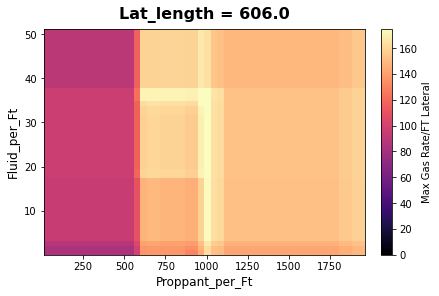

In [16]:
#Heatmap 1 thrid dimension is from max_features
dict_plotting_args = {'cmap':plt.cm.magma,'vmin':0,'vmax':175,'aspect':'auto',
                     'origin':'lower'}

plot_meshgrid(dict_kwargs1, dict_plotting_args)

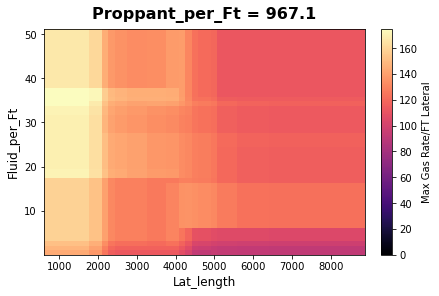

In [17]:
#Heatmap 2
plot_meshgrid(dict_kwargs2, dict_plotting_args)

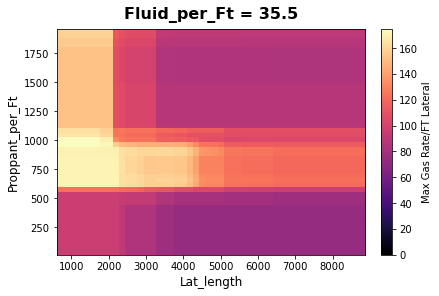

In [18]:
#Heatmap 3
plot_meshgrid(dict_kwargs3, dict_plotting_args)

In [19]:
#User inputs for third dimension attributes
user_features = max_features.copy()
user_features['Fluid_per_Ft'] = 70
user_features['Lat_length']= 4000
user_features['Proppant_per_Ft'] = 1600
user_features

Fluid_per_Ft         70.0
Lat_length         4000.0
Proppant_per_Ft    1600.0
Name: 1724, dtype: float64

In [20]:
#These dictionaries define the inputs for the "heatmaps" with USER INPUT
#heatmap 1 w/User Input
dict_kwargs4 = {'trained_model':model_gbm,'X':X_train,'y':y_train,
               'str_feature1':'Proppant_per_Ft','str_feature2':'Fluid_per_Ft','str_feature3':'Lat_length',
               'ser_vals3':user_features,'nsteps':50}
#heatmap 2 w/User Input
dict_kwargs5 = {'trained_model':model_gbm,'X':X_train,'y':y_train,
               'str_feature1':'Lat_length','str_feature2':'Fluid_per_Ft','str_feature3':'Proppant_per_Ft',
               'ser_vals3':user_features,'nsteps':50}
#heatmap 3 w/User Input
dict_kwargs6 = {'trained_model':model_gbm,'X':X_train,'y':y_train,
               'str_feature1':'Lat_length','str_feature2':'Proppant_per_Ft','str_feature3':'Fluid_per_Ft',
               'ser_vals3':user_features,'nsteps':50}

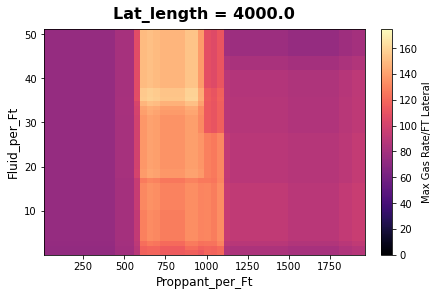

In [21]:
#Heatmap 1 User Input
plot_meshgrid(dict_kwargs4, dict_plotting_args)

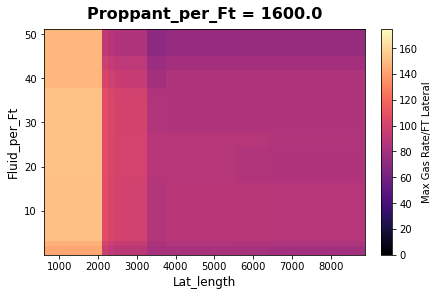

In [22]:
#Heatmap 2 User Input
plot_meshgrid(dict_kwargs5, dict_plotting_args)

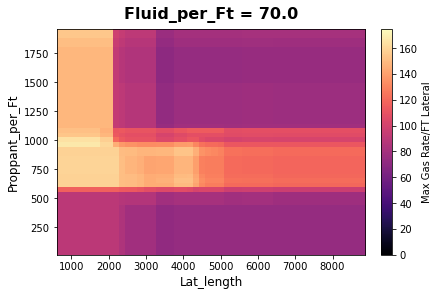

In [23]:
#Heatmap 3 User Input
plot_meshgrid(dict_kwargs6, dict_plotting_args)